<a href="https://colab.research.google.com/github/Praise-Atadja/heart-disease-analysis/blob/main/heart_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **PROJECT NAME:**

# Heart Disease Dataset Analysis

---
(This project is to use unsupervised learning techniques to cluster patients based on their medical history and identify risk factors associated with heart disease.)

(The task is to analyze a dataset of medical records to identify patients with high risk of developing heart disease.)

# Install necessary libraries

In [1]:
pip install ucimlrepo

In [2]:
pip install scikit-learn

# Import necessary libraries

In [7]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer

# 1. Load Datasets

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

# 2. Preprocess Cleveland data

In [5]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
df = pd.read_csv(url, header=None, names=column_names)

# Perform EDA
print(df.head())
print(df.info())
print(df.describe())



    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-n

In [23]:
# Handle missing values by replacing '?' with NaN and then dropping rows with NaN values
df = df.replace('?', np.nan)
df = df.dropna()

# Convert categorical variables to numeric
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for feature in categorical_features:
    # Attempt to convert to integers, handling potential errors
    try:
        df[feature] = df[feature].astype(int)
    except ValueError:
        print(f"Could not convert column '{feature}' to integers. Investigating values...")
        print(df[feature].unique())  # Print unique values in the problematic column

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('target', axis=1))

# Create a DataFrame with the scaled features
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[:-1])

# Add the target variable
df_scaled['target'] = df['target']

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
df_scaled_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_scaled.columns)

# Split the data into features and target
X = df_scaled_imputed.drop('target', axis=1)
y = df_scaled_imputed['target']


Could not convert column 'ca' to integers. Investigating values...
['0.0' '3.0' '2.0' '1.0']
Could not convert column 'thal' to integers. Investigating values...
['6.0' '3.0' '7.0']


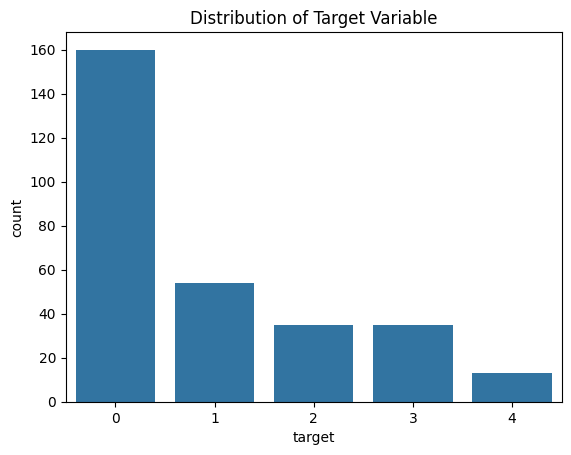

In [24]:
# Visualize the distribution of target variable
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.show()

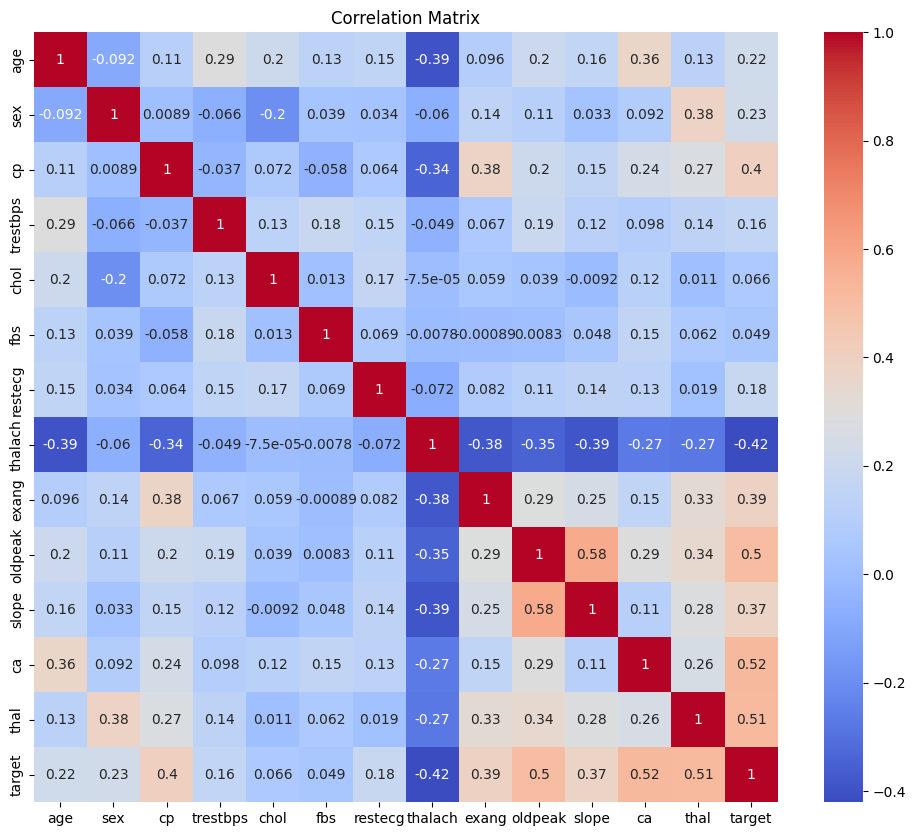

In [11]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Apply Clustering Algorithms

Apply K-means clustering


In [25]:
# Apply K-means clustering with explicit n_init parameter
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Output the KMeans labels
print("K-means clustering labels:")
print(kmeans_labels)

K-means clustering labels:
[0 1 1 3 2 3 1 2 1 1 3 2 0 3 0 3 3 3 2 3 3 0 3 1 1 2 2 2 3 1 2 0 3 3 3 3 1
 1 1 0 1 3 2 0 2 1 3 1 0 0 2 3 3 3 1 1 3 3 3 3 1 2 1 0 1 1 3 3 1 3 2 0 1 3
 3 2 1 2 3 1 1 2 3 0 3 3 3 2 2 2 1 1 2 2 3 1 1 3 3 3 3 2 0 1 3 3 3 1 3 1 0
 3 1 1 3 0 2 0 1 0 1 3 1 0 2 1 1 3 2 3 3 3 3 2 2 1 1 1 0 3 3 0 1 1 3 0 3 3
 2 0 2 2 1 1 1 3 3 1 3 0 1 2 2 0 3 0 3 2 1 1 2 2 1 1 0 1 3 0 3 1 3 1 2 2 0
 1 3 1 3 1 0 2 1 0 2 2 3 2 2 0 2 3 1 1 1 3 2 2 3 3 0 3 3 2 2 2 3 2 2 2 1 2
 2 3 2 1 1 2 1 3 2 2 1 1 3 2 3 3 2 2 3 0 1 3 1 3 0 1 1 1 2 3 2 2 2 3 3 2 0
 2 3 1 1 0 3 3 1 1 1 2 3 3 2 2 3 2 1 3 1 3 3 1 0 3 3 1 2 1 1 2 3 0 1 3 0 1
 2]


Apply Hierarchical clustering

In [26]:
# Apply Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(X)

# Output the Hierarchical labels
print("Hierarchical clustering labels:")
print(hierarchical_labels)

Hierarchical clustering labels:
[2 1 1 0 3 0 1 3 0 2 0 3 2 0 2 0 0 0 3 0 1 2 0 0 1 3 3 1 0 1 3 2 0 0 0 0 1
 1 1 2 1 0 3 2 3 0 0 0 2 2 3 0 0 0 0 1 0 0 0 1 1 3 1 2 1 1 0 0 1 0 3 2 1 0
 0 3 1 3 0 1 1 1 0 2 0 0 0 3 3 0 1 0 3 3 0 1 1 0 0 0 0 3 2 0 0 0 0 1 1 1 2
 0 2 1 0 2 3 2 0 2 1 1 1 2 3 2 1 0 3 0 0 0 0 3 3 1 1 1 2 0 0 2 1 1 0 2 0 0
 3 2 1 3 1 1 1 0 0 0 0 0 0 3 1 2 0 2 0 3 1 1 3 3 0 1 2 1 0 2 0 1 0 1 3 3 2
 1 0 0 0 1 2 1 1 2 3 3 0 3 3 2 1 0 1 1 1 0 3 3 0 0 2 0 0 3 3 1 0 3 3 3 1 1
 3 0 3 1 1 3 1 0 1 3 1 2 0 3 0 0 3 3 0 2 1 0 1 0 2 1 1 1 3 0 3 1 1 0 0 3 2
 3 0 1 1 2 0 0 1 0 1 1 0 0 3 3 0 1 1 0 1 0 0 1 2 0 0 0 3 1 1 1 0 2 1 0 2 1
 3]


Apply DBSCAN clustering

In [27]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Output the DBSCAN labels
print("DBSCAN labels:")
print(dbscan_labels)

DBSCAN labels:
[-1 -1  2 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1
  2  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  0 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0 -1 -1 -1 -1 -1 -1]


# 4. Visualize the Clusters

PCA visualization

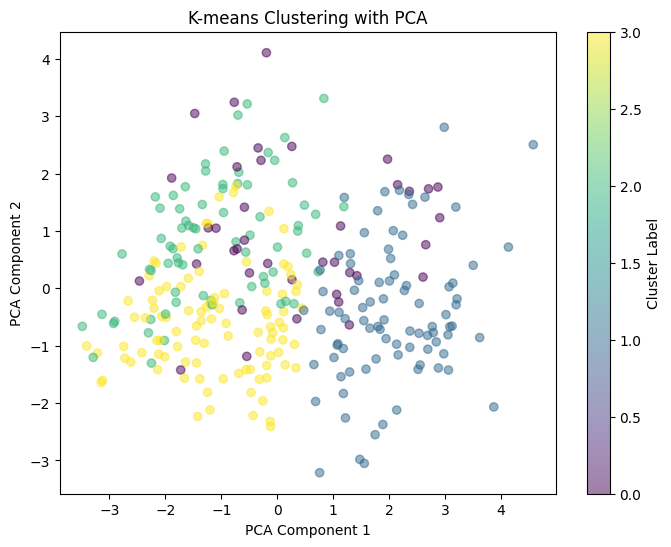

In [28]:
# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

t-SNE visualization

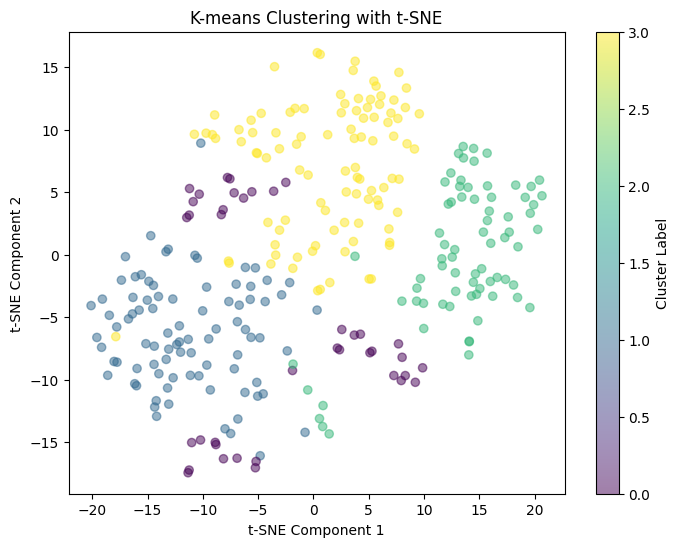

In [29]:
# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# 5. Gaussian Mixture Models

In [30]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Output the GMM labels
print("GMM labels:")
print(gmm_labels)

GMM labels:
[0 1 1 2 2 2 2 0 2 1 2 2 1 2 1 2 2 2 2 2 0 0 2 2 1 2 2 2 2 1 2 1 2 2 0 2 1
 1 1 1 2 0 2 0 2 2 2 2 0 0 2 2 2 2 1 1 2 2 2 0 1 0 1 0 2 1 2 2 1 2 2 1 1 2
 2 2 1 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 0 2 2 1 2 1 2 1 1
 2 1 2 2 0 2 1 2 1 2 1 1 0 2 1 1 2 2 2 1 2 0 2 2 1 2 1 0 0 2 0 1 1 2 1 2 2
 2 0 2 0 1 1 2 1 2 2 2 0 1 2 2 1 1 0 1 2 1 1 0 2 2 1 1 1 2 1 2 1 2 2 2 2 0
 1 2 2 2 1 1 2 1 0 0 2 2 2 0 1 2 2 1 1 1 2 0 2 0 2 1 2 2 2 0 2 2 0 2 2 1 1
 2 2 2 1 1 2 1 2 0 2 1 1 2 2 2 2 2 2 2 0 2 2 1 2 0 1 2 1 2 2 2 2 2 2 2 2 0
 2 2 1 1 1 2 2 1 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 1 1 0 2 1 1 2 1 1
 2]


# 6. Evaluate Clustering Performance


Applying silhouette score and Davies-Bouldin index.


In [33]:
# Evaluate K-means
kmeans_silhouette = silhouette_score(df_scaled_imputed.drop('target', axis=1), kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(df_scaled_imputed.drop('target', axis=1), kmeans_labels)

# Evaluate Hierarchical clustering
hierarchical_silhouette = silhouette_score(df_scaled_imputed.drop('target', axis=1), hierarchical_labels)
hierarchical_davies_bouldin = davies_bouldin_score(df_scaled_imputed.drop('target', axis=1), hierarchical_labels)

# Evaluate DBSCAN
# Only evaluate if there are more than 1 cluster formed (Silhouette score requires at least 2 clusters)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(df_scaled_imputed.drop('target', axis=1), dbscan_labels)
    dbscan_davies_bouldin = davies_bouldin_score(df_scaled_imputed.drop('target', axis=1), dbscan_labels)
else:
    dbscan_silhouette = 'N/A'
    dbscan_davies_bouldin = 'N/A'

# Evaluate GMM
gmm_silhouette = silhouette_score(df_scaled_imputed.drop('target', axis=1), gmm_labels)
gmm_davies_bouldin = davies_bouldin_score(df_scaled_imputed.drop('target', axis=1), gmm_labels)

print(f"K-means Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Score: {kmeans_davies_bouldin}")
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette}, Davies-Bouldin Score: {hierarchical_davies_bouldin}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Score: {dbscan_davies_bouldin}")
print(f"GMM Silhouette Score: {gmm_silhouette}, Davies-Bouldin Score: {gmm_davies_bouldin}")


K-means Silhouette Score: 0.13297082826291673, Davies-Bouldin Score: 2.083096797124705
Hierarchical Silhouette Score: 0.10447555773556846, Davies-Bouldin Score: 2.1748353277579637
DBSCAN Silhouette Score: -0.18729250849801815, Davies-Bouldin Score: 1.6108862796863535
GMM Silhouette Score: 0.11044256886456398, Davies-Bouldin Score: 3.1166146402933244


# 7. Compare Clustering Algorithms

In [38]:
results = {
    'Algorithm': ['K-means', 'Hierarchical', 'DBSCAN', 'GMM'],
    'Silhouette Score': [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette, gmm_silhouette],
    'Davies-Bouldin Score': [kmeans_davies_bouldin, hierarchical_davies_bouldin, dbscan_davies_bouldin, gmm_davies_bouldin]
}

results_df = pd.DataFrame(results)
print(results_df)

# Determine the best algorithm based on scores
best_algorithm = results_df.loc[results_df['Silhouette Score'].idxmax()]

print("\nBest clustering algorithm based on Silhouette Score:")
print(best_algorithm)

      Algorithm  Silhouette Score  Davies-Bouldin Score
0       K-means          0.132971              2.083097
1  Hierarchical          0.104476              2.174835
2        DBSCAN         -0.187293              1.610886
3           GMM          0.110443              3.116615

Best clustering algorithm based on Silhouette Score:
Algorithm                K-means
Silhouette Score        0.132971
Davies-Bouldin Score    2.083097
Name: 0, dtype: object
